# MSiA 420 - Predictive Analytics II - Final Project
## Group 6: Alejandra Lelo de Larrea Ibarra, Kiran Jyothi Sheena, Lixuan (Ellen) Chen, Wencheng Zhang

# Logistic Regression

Tutorial: https://www.justintodata.com/logistic-regression-example-in-python/

In [33]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.tools import add_constant

import time 
from alepython import ale_plot

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
#from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

# Data

In [2]:
# df clean 
df_clean = pd.read_csv("../02_Data/hotel_bookings_clean.csv")
df_clean.head()

,hotel,is_canceled,arrival_date_year,adults,children,babies,meal,market_segment,is_repeated_guest,previous_cancellations,...,total_nights,domestic,continent,previous_bookings,got_room_booked,booked_by_agent,booked_by_company,log_days_in_waiting_list,log_adr,required_car_parking
0,Resort Hotel,0,2015,2,0,0,BB,Direct,0,0,...,0,domestic,Europe,0,1,no,0,0.0,0.000000,0
1,Resort Hotel,0,2015,2,0,0,BB,Direct,0,0,...,0,domestic,Europe,0,1,no,0,0.0,0.000000,0
2,Resort Hotel,0,2015,1,0,0,BB,Direct,0,0,...,1,international,Europe,0,0,no,0,0.0,4.330733,0
3,Resort Hotel,0,2015,1,0,0,BB,Corporate,0,0,...,1,international,Europe,0,1,yes,0,0.0,4.330733,0
4,Resort Hotel,0,2015,2,0,0,BB,Online TA,0,0,...,2,international,Europe,0,1,yes,0,0.0,4.595120,0


In [3]:
df_clean.dtypes

hotel                         object
is_canceled                    int64
arrival_date_year              int64
adults                         int64
children                       int64
babies                         int64
meal                          object
market_segment                object
is_repeated_guest              int64
previous_cancellations         int64
booking_changes                int64
deposit_type                  object
customer_type                 object
total_of_special_requests      int64
arrival_month                  int64
log_lead_time                float64
total_nights                   int64
domestic                      object
continent                     object
previous_bookings              int64
got_room_booked                int64
booked_by_agent               object
booked_by_company              int64
log_days_in_waiting_list     float64
log_adr                      float64
required_car_parking           int64
dtype: object

In [4]:
cats = ["is_canceled","hotel", "meal", "market_segment", "is_repeated_guest",
        "deposit_type", "customer_type", "arrival_month", "domestic", "continent", 
        "got_room_booked", "booked_by_agent", "booked_by_company", "required_car_parking"]

for c in cats:
    print(df_clean[c].value_counts())
    print("\n\n")

0    75165
1    44223
Name: is_canceled, dtype: int64



City Hotel      79329
Resort Hotel    40059
Name: hotel, dtype: int64



BB           92308
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64



Online TA        56477
Offline TA/TO    24218
Groups           19810
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64



0    115579
1      3809
Name: is_repeated_guest, dtype: int64



No Deposit    104640
Non Refund     14586
Refundable       162
Name: deposit_type, dtype: int64



Transient          89612
Transient-Party    25123
Contract            4076
Group                577
Name: customer_type, dtype: int64



8     13877
7     12661
5     11791
10    11160
4     11089
6     10939
9     10508
3      9792
2      8068
11     6794
12     6780
1      5929
Name: arrival_month, dtype: int64



international    70799
domestic         485

In [5]:
# get train indexes
train_ind = pd.read_csv("../02_Data/train_index.csv")

# split train
train_clean = df_clean.iloc[train_ind.Train_Index,:]
train_clean.reset_index(inplace = True, drop = True)

# Split test 
test_clean = df_clean.iloc[df_clean.index.difference(train_ind.Train_Index),:]

In [6]:
for c in cats:
    print(train_clean[c].value_counts())
    print("\n\n")

0    60116
1    35395
Name: is_canceled, dtype: int64



City Hotel      63467
Resort Hotel    32044
Name: hotel, dtype: int64



BB           73859
HB           11536
SC            8542
Undefined      910
FB             664
Name: meal, dtype: int64



Online TA        45149
Offline TA/TO    19477
Groups           15800
Direct           10093
Corporate         4219
Complementary      581
Aviation           190
Undefined            2
Name: market_segment, dtype: int64



0    92491
1     3020
Name: is_repeated_guest, dtype: int64



No Deposit    83735
Non Refund    11635
Refundable      141
Name: deposit_type, dtype: int64



Transient          71660
Transient-Party    20119
Contract            3280
Group                452
Name: customer_type, dtype: int64



8     11031
7     10180
5      9508
10     8875
4      8854
6      8785
9      8476
3      7824
2      6460
12     5420
11     5410
1      4688
Name: arrival_month, dtype: int64



international    56697
domestic         38814
Na

Market segment "undefine" has onl 2 observations, and both of them are in the train set. Also continent "Antartica" has only 2 observations, which are only in the train set. This 2 cateogries might cause problems with logistic regression because when using CV some folds might have a column of zeros. I will remove this observations from the analysis. 

In [7]:
# Find indexes to later remove them in the dummy variable
idx = np.concatenate([df_clean[df_clean["continent"]=="Antarctica"].index.values,
       df_clean[df_clean["market_segment"] == "Undefined"].index.values])
idx 

array([ 99596, 104760,  40599,  40678])

In [8]:
# read dummy data
df = pd.read_csv("../02_Data/hotel_bookings_dummy.csv")

# Remove poblematic rows
df.head()

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
0,2,2015,7,0,0,0,3,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,2,2015,7,0,0,0,4,0,1,1,...,0,1,0,0,0,0,0,0,0,0
2,1,2015,7,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,2015,7,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,2,2015,7,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [9]:
# Check data types 
df.dtypes

adults                             int64
arrival_date_year                  int64
arrival_month                      int64
babies                             int64
booked_by_agent                    int64
booked_by_company                  int64
booking_changes                    int64
children                           int64
domestic                           int64
got_room_booked                    int64
hotel                              int64
is_canceled                        int64
is_repeated_guest                  int64
log_adr                          float64
log_days_in_waiting_list         float64
log_lead_time                    float64
previous_bookings                  int64
previous_cancellations             int64
required_car_parking               int64
total_nights                       int64
total_of_special_requests          int64
continent_Americas                 int64
continent_Antarctica               int64
continent_Asia                     int64
continent_Europe

In [10]:
# Number of observations and features
df.shape

(119388, 43)

In [11]:
# descriptive stats 
df.describe()

,adults,arrival_date_year,arrival_month,babies,booked_by_agent,booked_by_company,booking_changes,children,domestic,got_room_booked,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,meal_FB,meal_HB,meal_SC,meal_Undefined
count,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,...,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000,119388.000000
mean,1.856401,2016.156548,6.552543,0.007949,0.863135,0.056932,0.221103,0.103888,0.406984,0.875063,...,0.044351,0.105589,0.165930,0.202851,0.473054,0.000017,0.006684,0.121143,0.089205,0.009792
std,0.579266,0.707478,3.090610,0.097437,0.343706,0.231714,0.652287,0.398558,0.491274,0.330649,...,0.205875,0.307312,0.372019,0.402124,0.499275,0.004093,0.081483,0.326295,0.285041,0.098467
min,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2016.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2016.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2017.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,55.000000,2017.000000,12.000000,10.000000,1.000000,1.000000,21.000000,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# check null values 
df.isna().sum()

adults                           0
arrival_date_year                0
arrival_month                    0
babies                           0
booked_by_agent                  0
booked_by_company                0
booking_changes                  0
children                         0
domestic                         0
got_room_booked                  0
hotel                            0
is_canceled                      0
is_repeated_guest                0
log_adr                          0
log_days_in_waiting_list         0
log_lead_time                    0
previous_bookings                0
previous_cancellations           0
required_car_parking             0
total_nights                     0
total_of_special_requests        0
continent_Americas               0
continent_Antarctica             0
continent_Asia                   0
continent_Europe                 0
continent_Oceania                0
continent_unknown                0
customer_type_Group              0
customer_type_Transi

In [13]:
# Print feature names 
df.columns

Index(['adults', 'arrival_date_year', 'arrival_month', 'babies',
       'booked_by_agent', 'booked_by_company', 'booking_changes', 'children',
       'domestic', 'got_room_booked', 'hotel', 'is_canceled',
       'is_repeated_guest', 'log_adr', 'log_days_in_waiting_list',
       'log_lead_time', 'previous_bookings', 'previous_cancellations',
       'required_car_parking', 'total_nights', 'total_of_special_requests',
       'continent_Americas', 'continent_Antarctica', 'continent_Asia',
       'continent_Europe', 'continent_Oceania', 'continent_unknown',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Undefined', 'meal_FB',
       'meal_HB', 'meal_SC', 'meal_Undefined'],
     

## Splitting training and test 

In [14]:
# get train indexes
train_ind = pd.read_csv("../02_Data/train_index.csv")

# Remove problematic rows.
train_ind = train_ind[~train_ind.Train_Index.isin(idx)]  

# split train
train = df.copy()
train = train.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)

# Split test 
test = df.copy()
test = test.iloc[df.index.difference(train_ind.Train_Index),:]

# Remove continent_antarctica & market_segment_Undefined
train.drop("continent_Antarctica", axis = 1, inplace = True)
train.drop("market_segment_Undefined", axis = 1, inplace = True)
test.drop("continent_Antarctica", axis = 1, inplace = True)
test.drop("market_segment_Undefined", axis = 1, inplace = True)

In [15]:
# Check class imbalance in train and test 
print("Train Class Response:")
print(train.is_canceled.value_counts()/train.shape[0]*100)

print("Test Class Response:")
print(test.is_canceled.value_counts()/test.shape[0]*100)

Train Class Response:
0    62.941983
1    37.058017
Name: is_canceled, dtype: float64
Test Class Response:
0    63.024999
1    36.975001
Name: is_canceled, dtype: float64


## Scaling data

In [16]:
# Scale numeric columns 
scaler = StandardScaler()
scaler.fit(train.drop("is_canceled", axis = 1))

# Scale train data
xtrain = scaler.transform(train.drop("is_canceled", axis = 1))
ytrain = train.is_canceled

In [17]:
# Scale test data with train scaler 
xtest = scaler.transform(test.drop("is_canceled", axis = 1))
ytest = test.is_canceled

## Logistic regression with Regularization & CV

In [18]:
# Create logistic regression object 
logistic = LogisticRegression(max_iter = 4000, solver = 'saga')

# list of penalty
penalty = ['l1','l2']

# list of alphas 
alpha = [0.01, 0.1, 0.5, 1]
C = [1/i for i in alpha]

# Combine hyperparams 
hyperparams = dict(C=C, penalty = penalty)

# Use gridsearch to fit model 
cv_hyper = GridSearchCV(logistic, hyperparams, cv = 10,  verbose = 0)
best_mod = cv_hyper.fit(xtrain,ytrain)

print("Best penalty:", best_mod.best_estimator_.get_params()['penalty'])
print("Best C:", best_mod.best_estimator_.get_params()['C'])

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/sit

Best penalty: l2
Best C: 10.0


In [29]:
# Get best hyperparams 
penalty_star = best_mod.best_estimator_.get_params()['penalty']
C_star = best_mod.best_estimator_.get_params()['C']

# set timer 
training_time = time.time()

#Run optimal model
logistic = LogisticRegression(max_iter = 4000, solver = 'saga', C = C_star, penalty = penalty_star)
logistic.fit(xtrain, ytrain)

# Stop timer 
training_time = time.time() - training_time

print("Training time: " + str(training_time))

Training time: 105.1381402015686


In [27]:
#!pip install setuptools==58
#!pip install regressors

from sklearn.linear_model import Ridge
from regressors import stats

ridgemod = Ridge(alpha = 1/C_star, normalize = True)
ridgemod.fit(xtrain, ytrain)

stats.summary(ridgemod,xtrain,ytrain)

Residuals:
    Min     1Q  Median     3Q    Max
-0.7768 0.1729  0.3349 0.5071 1.5945


Coefficients:
            Estimate  Std. Error   t value   p value
_intercept  0.370580    0.001182  313.4497  0.000000
x1          0.013047    0.001261   10.3428  0.000000
x2          0.012114    0.001458    8.3069  0.000000
x3          0.005266    0.001374    3.8336  0.000126
x4          0.000621    0.001192    0.5209  0.602439
x5          0.001589    0.001675    0.9491  0.342593
x6         -0.010165    0.001868   -5.4408  0.000000
x7         -0.023985    0.001220  -19.6647  0.000000
x8          0.011721    0.001221    9.5999  0.000000
x9          0.129946    0.001431   90.8251  0.000000
x10         0.052032    0.001241   41.9399  0.000000
x11        -0.007459    0.001371   -5.4386  0.000000
x12        -0.002667    0.001353   -1.9703  0.048802
x13         0.019310    0.001451   13.3054  0.000000
x14        -0.003168    0.001230   -2.5758  0.010001
x15         0.091732    0.001486   61.7364  0.00000

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [70]:
signif = pd.DataFrame({"Var":['intercept'] + list(train.columns.difference(['is_canceled'])),
                       "Estimate":np.hstack([ridgemod.intercept_, ridgemod.coef_]),
                       "StdError":stats.coef_se(ridgemod,xtrain,ytrain),
                      "tValue":stats.coef_tval(ridgemod,xtrain,ytrain),
                      "pvals":stats.coef_pval(ridgemod,xtrain,ytrain)})
signif["Is Significant"] = np.where(signif.pvals<=0.05, "yes", "no")
signif

,Var,Estimate,StdError,tValue,pvals,Is Significant
0,intercept,0.370580,0.001182,313.449680,0.000000e+00,yes
1,adults,0.013047,0.001261,10.342817,0.000000e+00,yes
2,arrival_date_year,0.012114,0.001458,8.306857,2.220446e-16,yes
3,arrival_month,0.005266,0.001374,3.833599,1.263627e-04,yes
4,babies,0.000621,0.001192,0.520899,6.024385e-01,no
5,booked_by_agent,0.001589,0.001675,0.949059,3.425929e-01,no
6,booked_by_company,-0.010165,0.001868,-5.440838,5.316028e-08,yes
7,booking_changes,-0.023985,0.001220,-19.664697,0.000000e+00,yes
8,children,0.011721,0.001221,9.599923,0.000000e+00,yes
9,continent_Americas,0.129946,0.001431,90.825120,0.000000e+00,yes


array([ 3.70580167e-01,  1.30467497e-02,  1.21136928e-02,  5.26577189e-03,
        6.21118769e-04,  1.58921252e-03, -1.01645245e-02, -2.39847983e-02,
        1.17213806e-02,  1.29946481e-01,  5.20316744e-02, -7.45876137e-03,
       -2.66664858e-03,  1.93097664e-02, -3.16764878e-03,  9.17317095e-02,
       -7.01630124e-03,  2.27077807e-02, -5.37216827e-02,  1.30319197e-02,
       -8.05583240e-02, -8.80086661e-03, -4.40843608e-03, -2.95147405e-02,
       -7.40936153e-03,  7.13356982e-03, -2.06868370e-03,  2.76555393e-02,
       -1.35700200e-02,  1.22224837e-01,  1.19655753e-04,  3.45606958e-03,
       -8.94924647e-03, -2.25120386e-02, -5.14254520e-03, -4.05656206e-02,
        5.23908927e-02,  5.03099960e-04, -4.73969602e-03,  9.22915546e-03,
       -9.10486150e-03])

In [30]:
# Predictions for test 
yhat_test = logistic.predict(xtest)

# --- Metrics---
conf_matrix = confusion_matrix(ytest, yhat_test)
print('--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(ytest, yhat_test)))
print('Precision = {:.5f}'.format(precision_score(ytest, yhat_test)))
print('Recall = {:.5f}'.format(recall_score(ytest, yhat_test)))
print('F1 score = {:.5f}'.format(f1_score(ytest, yhat_test)))

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13683  1368]
 [ 2764  6066]]

Using 0.5 as threshold:
Accuracy = 0.82698
Precision = 0.81598
Recall = 0.68698
F1 score = 0.74594


/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


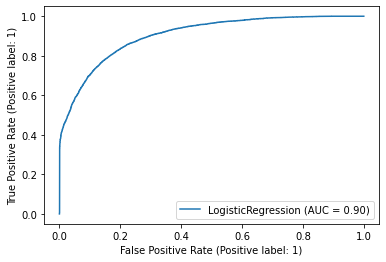

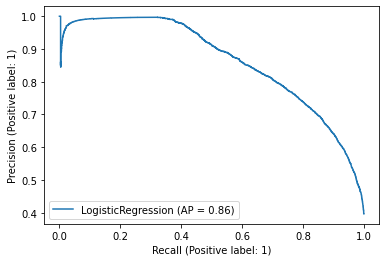

In [31]:
# ROC curve
plot_roc_curve(logistic, xtest, ytest)

# Precision-recall curve 
plot_precision_recall_curve(logistic, xtest, ytest)

## Variable Importance

### Main plot effects

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


<Figure size 432x288 with 0 Axes>

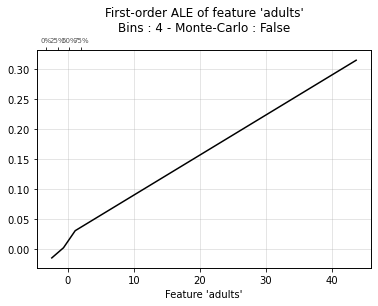

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


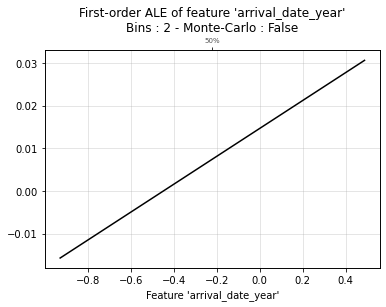

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


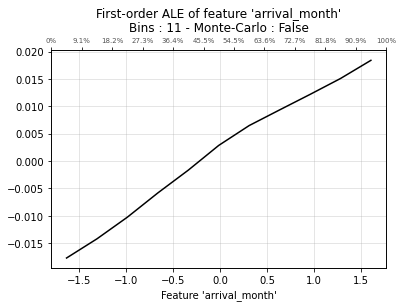

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


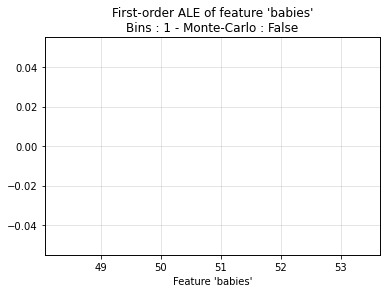

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


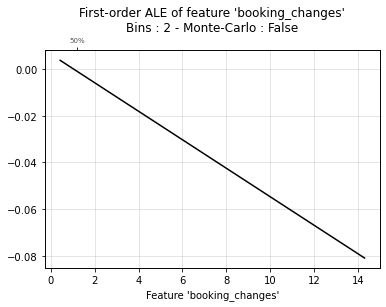

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


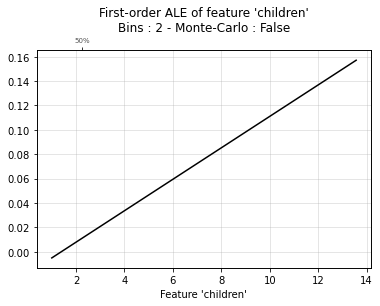

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


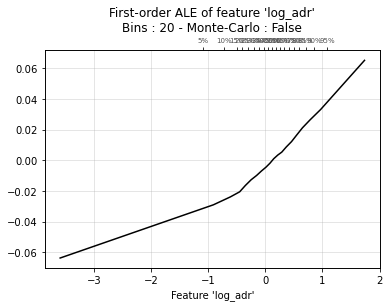

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


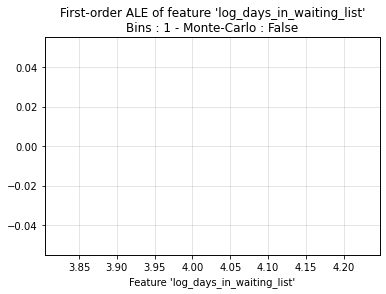

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


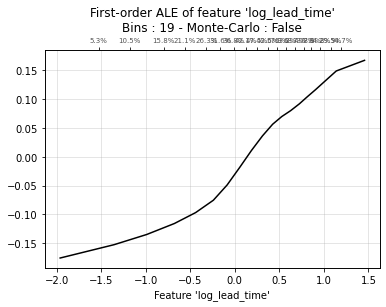

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


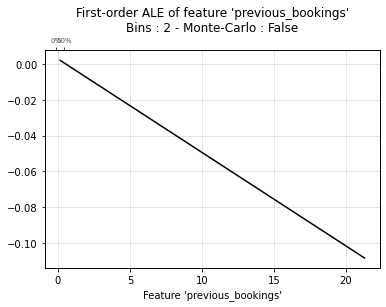

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


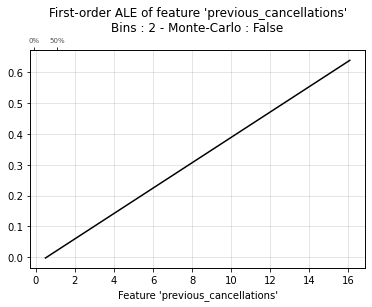

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


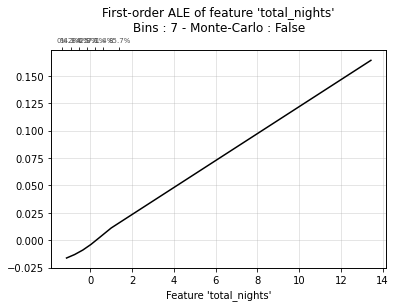

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


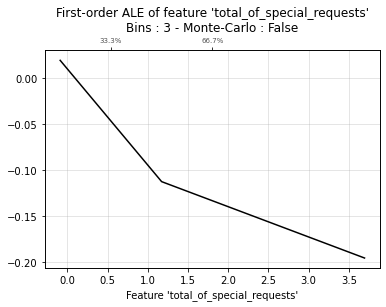

In [46]:
# convert xtrain to dataframe 
aux = pd.DataFrame(xtrain)
aux.columns = train.drop("is_canceled", axis = 1).columns

# Select numerical variables 
num_cols = ['adults', 'arrival_date_year', 'arrival_month', 
            'babies', 'booking_changes', 'children', 'log_adr',
            'log_days_in_waiting_list', 'log_lead_time',
            'previous_bookings', 'previous_cancellations', 'total_nights',
            'total_of_special_requests']
  
# Run main plot effects 
fig = plt.figure()
for i in num_cols:
    ale_plot(logistic, aux, i, bins=20)

### Second order effects

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


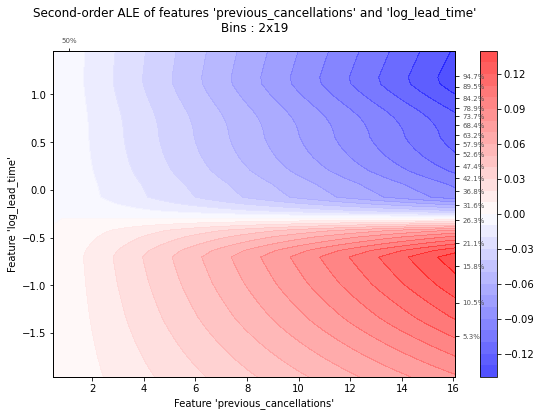

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


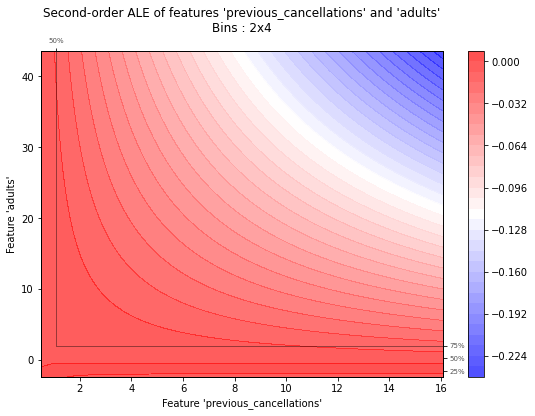

/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/alelli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


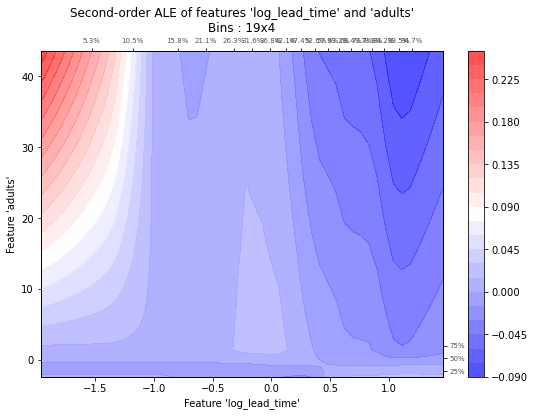

<AxesSubplot:title={'center':"Second-order ALE of features 'log_lead_time' and 'adults'\nBins : 19x4"}, xlabel="Feature 'log_lead_time'", ylabel="Feature 'adults'">

In [48]:
# Range from 1st effect plots
#previous cancellations = 0.65
#log_lead_time > 0.3
#adults = 0.3
#total_of_special_requests = 0.2
#children = 0.16
#total_nigths 0.15
#log_adr = 0.12
#previous bookings = 0.1

# Plot interactions
plt.rc("figure", figsize = (9,6))
ale_plot(logistic, aux, ["previous_cancellations","log_lead_time"], bins=20)
ale_plot(logistic, aux, ["previous_cancellations", "adults"], bins=20)
ale_plot(logistic, aux, ["log_lead_time", "adults"], bins=20)